# T81-558: Applications of Deep Neural Networks
**Class 10: Recurrent and LSTM Networks**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Common Functions

Some of the common functions from previous classes that we will use again.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y,sort=False):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name]-df[name].mean())>=(sd*df[name].std()))]
    df.drop(drop_rows,axis=0,inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low =-1, normalized_high =1, 
                         data_low=None, data_high=None):
    
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                * (normalized_high - normalized_low) + normalized_low

In [ ]:
sk

# TensorFlow Graphs

So far we've communicated with TensorFlow using TensorFlow Learn, which allows you to specify the number of hidden layers and simply create the neural network.  

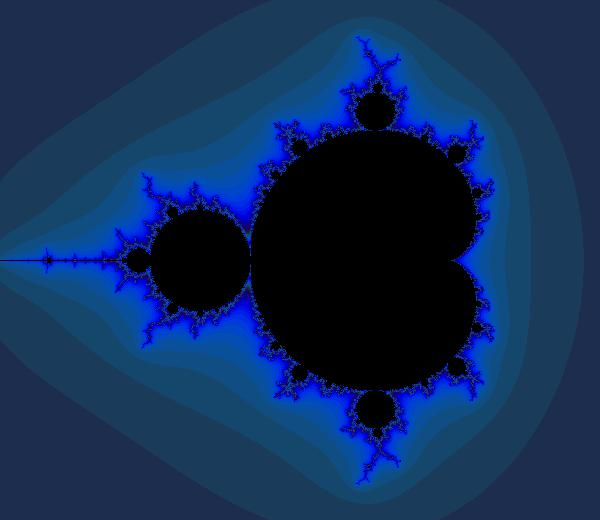

In [1]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np

# Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import Image, display

def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

sess = tf.InteractiveSession()

# Use NumPy to create a 2D array of complex numbers

Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
Z = X+1j*Y

xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))

tf.global_variables_initializer().run()

# Compute the new values of z: z^2 + x
zs_ = zs*zs + xs

# Have we diverged with this new value?
not_diverged = tf.abs(zs_) < 4

# Operation to update the zs and the iteration count.
#
# Note: We keep computing zs after they diverge! This
#       is very wasteful! There are better, if a little
#       less simple, ways to do this.
#
step = tf.group(
  zs.assign(zs_),
  ns.assign_add(tf.cast(not_diverged, tf.float32))
  )

for i in range(200): step.run()
    
DisplayFractal(ns.eval())

In [2]:
import tensorflow as tf

# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
#
# The value returned by the constructor represents the output
# of the Constant op.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
product = tf.matmul(matrix1, matrix2)

with tf.Session() as sess:
  result = sess.run([product])
  print(result)

[array([[ 12.]], dtype=float32)]


In [3]:
# Enter an interactive TensorFlow Session.
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

# Initialize 'x' using the run() method of its initializer op.
x.initializer.run()

# Add an op to subtract 'a' from 'x'.  Run it and print the result
sub = tf.subtract(x, a)
print(sub.eval())
# ==> [-2. -1.]

[-2. -1.]


In [4]:
sess.run(x.assign([4.0, 6.0]))

array([ 4.,  6.], dtype=float32)

In [5]:
print(sub.eval())

[ 1.  3.]


In [7]:
# Close the Session when we're done.
sess.close()

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 784])

W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

In [9]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()

tf.global_variables_initializer().run()

for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [10]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9133


# Data Structure for Recurrent Neural Networks

Previously we trained neural networks with input ($x$) and expected output ($y$).  $X$ was a matrix, the rows were training examples and the columns were values to be predicted.  The definition of $x$ will be expanded and y will stay the same.

Dimensions of training set ($x$):
* Axis 1: Training set elements (sequences) (must be of the same size as $y$ size)
* Axis 2: Members of sequence
* Axis 3: Features in data (like input neurons)

Previously, we might take as input a single stock price, to predict if we should buy (1), sell (-1), or hold (0).

In [18]:
# 

x = [
    [30],
    [41],
    [39],
    [20],
    [15]
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[30], [41], [39], [20], [15]]
[1, -1, 0, -1, 1]


In [27]:
x.shape

(5, 1)

This is essentially building a CSV file from scratch, to see it as a data frame, use the following:

In [34]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

x = np.array(x)

print(x[:,0])


df = pd.DataFrame({'x':x[:,0], 'y':y})
display(df)

[30 41 39 20 15]


,x,y
0,30,1
1,41,-1
2,39,0
3,20,-1
4,15,1


You might want to put volume in with the stock price.  

In [35]:
x = [
    [32,1383],
    [41,2928],
    [39,8823],
    [20,1252],
    [15,1532]
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[32, 1383], [41, 2928], [39, 8823], [20, 1252], [15, 1532]]
[1, -1, 0, -1, 1]


Again, very similar to what we did before.  The following shows this as a data frame.

In [38]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

x = np.array(x)
print(x[:,0])


df = pd.DataFrame({'price':x[:,0], 'volume':x[:,1], 'y':y})
display(df)

[32 41 39 20 15]


,price,volume,y
0,32,1383,1
1,41,2928,-1
2,39,8823,0
3,20,1252,-1
4,15,1532,1


Now we get to sequence format.  We want to predict something over a sequence, so the data format needs to add a dimension.  A maximum sequence length must be specified, but the individual sequences can be of any length.

In [39]:
x = [
    [[32,1383],[41,2928],[39,8823],[20,1252],[15,1532]],
    [[35,8272],[32,1383],[41,2928],[39,8823],[20,1252]],
    [[37,2738],[35,8272],[32,1383],[41,2928],[39,8823]],
    [[34,2845],[37,2738],[35,8272],[32,1383],[41,2928]],
    [[32,2345],[34,2845],[37,2738],[35,8272],[32,1383]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[[32, 1383], [41, 2928], [39, 8823], [20, 1252], [15, 1532]], [[35, 8272], [32, 1383], [41, 2928], [39, 8823], [20, 1252]], [[37, 2738], [35, 8272], [32, 1383], [41, 2928], [39, 8823]], [[34, 2845], [37, 2738], [35, 8272], [32, 1383], [41, 2928]], [[32, 2345], [34, 2845], [37, 2738], [35, 8272], [32, 1383]]]
[1, -1, 0, -1, 1]


Even if there is only one feature (price), the 3rd dimension must be used:

In [7]:
x = [
    [[32],[41],[39],[20],[15]],
    [[35],[32],[41],[39],[20]],
    [[37],[35],[32],[41],[39]],
    [[34],[37],[35],[32],[41]],
    [[32],[34],[37],[35],[32]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[[32], [41], [39], [20], [15]], [[35], [32], [41], [39], [20]], [[37], [35], [32], [41], [39]], [[34], [37], [35], [32], [41]], [[32], [34], [37], [35], [32]]]
[1, -1, 0, -1, 1]


array([[0, 1, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [0, 1, 0]], dtype=int32)

In [63]:
sess = tf.InteractiveSession()
y = tf.one_hot([1, -1, 0, -1, 1], 2)
y.eval()

array([[ 0.,  1.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 0.,  0.],
       [ 0.,  1.]], dtype=float32)

In [78]:
"""
Lets assume you have 4 possible categories (cat, dog, bird, human) and 2 instances (cat, human).
So your depth=3 and your indices=[0, 3]
"""
# sess = tf.InteractiveSession()
with tf.Session() as sess:
    res = tf.one_hot([0, 1, 2, 3], 4, 1.0, 0.0)
    print(sess.run(res))

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]]


# Recurrent Neural Networks

So far the neural networks that we’ve examined have always had forward connections.  The input layer always connects to the first hidden layer.  Each hidden layer always connects to the next hidden layer.  The final hidden layer always connects to the output layer.  This manner to connect layers is the reason that these networks are called “feedforward.”  Recurrent neural networks are not so rigid, as backward connections are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself.  Most recurrent neural network architectures maintain state in the recurrent connections.  Feedforward neural networks don’t maintain any state.  A recurrent neural network’s state acts as a sort of short-term memory for the neural network.  Consequently, a recurrent neural network will not always produce the same output for a given input.

Recurrent neural networks do not force the connections to flow only from one layer to the next, from input layer to output layer.  A recurrent connection occurs when a connection is formed between a neuron and one of the following other types of neurons:

* The neuron itself
* A neuron on the same level
* A neuron on a previous level

Recurrent connections can never target the input neurons or the bias neurons.  
The processing of recurrent connections can be challenging. Because the recurrent links create endless loops, the neural network must have some way to know when to stop.  A neural network that entered an endless loop would not be useful.  To prevent endless loops, we can calculate the recurrent connections with the following three approaches:

* Context neurons
* Calculating output over a fixed number of iterations
* Calculating output until neuron output stabilizes

We refer to neural networks that use context neurons as a simple recurrent network (SRN).  The context neuron is a special neuron type that remembers its input and provides that input as its output the next time that we calculate the network.  For example, if we gave a context neuron 0.5 as input, it would output 0.  Context neurons always output 0 on their first call.  However, if we gave the context neuron a 0.6 as input, the output would be 0.5.  We never weight the input connections to a context neuron, but we can weight the output from a context neuron just like any other connection in a network.  

Context neurons allow us to calculate a neural network in a single feedforward pass.  Context neurons usually occur in layers.  A layer of context neurons will always have the same number of context neurons as neurons in its source layer, as demonstrated here:

![Context Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_context_layer.png "Context Layers")

As you can see from the above layer, two hidden neurons that are labeled hidden 1 and hidden 2 directly connect to the two context neurons.  The dashed lines on these connections indicate that these are not weighted connections. These weightless connections are never dense.  If these connections were dense, hidden 1 would be connected to both hidden 1 and hidden 2.  However, the direct connection simply joins each hidden neuron to its corresponding context neuron.  The two context neurons form dense, weighted connections to the two hidden neurons.  Finally, the two hidden neurons also form dense connections to the neurons in the next layer.  The two context neurons would form two connections to a single neuron in the next layer, four connections to two neurons, six connections to three neurons, and so on.

You can combine context neurons with the input, hidden, and output layers of a neural network in many different ways.  In the next two sections, we explore two common SRN architectures.

In 1990, Elman introduced a neural network that provides pattern recognition to time series.  This neural network type has one input neuron for each stream that you are using to predict.  There is one output neuron for each time slice you are trying to predict.  A single-hidden layer is positioned between the input and output layer.  A layer of context neurons takes its input from the hidden layer output and feeds back into the same hidden layer.  Consequently, the context layers always have the same number of neurons as the hidden layer, as demonstrated here:  

![Elman Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_elman.png "Elman Neural Network")

The Elman neural network is a good general-purpose architecture for simple recurrent neural networks.  You can pair any reasonable number of input neurons to any number of output neurons.  Using normal weighted connections, the two context neurons are fully connected with the two hidden neurons.  The two context neurons receive their state from the two non-weighted connections (dashed lines) from each of the two hidden neurons.

Backpropagation through time works by unfolding the SRN to become a regular neural network.  To unfold the SRN, we construct a chain of neural networks equal to how far back in time we wish to go.  We start with a neural network that contains the inputs for the current time, known as t.  Next we replace the context with the entire neural network, up to the context neuron’s input.  We continue for the desired number of time slices and replace the final context neuron with a 0.  The following diagram shows an unfolded Elman neural network for two time slices.

![Unfolding the Elman Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_elman_unfold.png "Unfolding the Elman Neural Network")

As you can see, there are inputs for both t (current time) and t-1 (one time slice in the past).  The bottom neural network stops at the hidden neurons because you don’t need everything beyond the hidden neurons to calculate the context input.  The bottom network structure becomes the context to the top network structure.  Of course, the bottom structure would have had a context as well that connects to its hidden neurons.  However, because the output neuron above does not contribute to the context, only the top network (current time) has one.


# Understanding LSTM

Some useful resources on LSTM/recurrent neural networks.

* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Recurrent Neural Networks in TensorFlow](https://www.tensorflow.org/versions/r0.11/tutorials/recurrent/index.html)

Long Short Term Neural Network (LSTM) are a type of recurrent unit that is often used with deep neural networks.  For TensorFlow, LSTM can be thought of as a layer type that can be combined with other layer types, such as dense.  LSTM makes use two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$$ \text{S}(t) = \frac{1}{1 + e^{-t}} $$

The second type of transfer function is the hyperbolic tangent (tanh) function.  This function is used to scale the output of the LSTM, similarly to how other transfer functions have been used in this course.  

The graphs for these functions are shown here:

Sigmoid


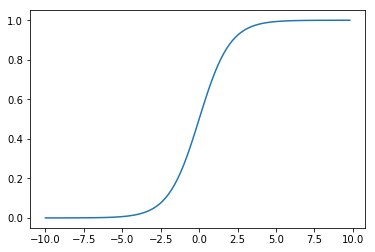

Hyperbolic Tangent(tanh)


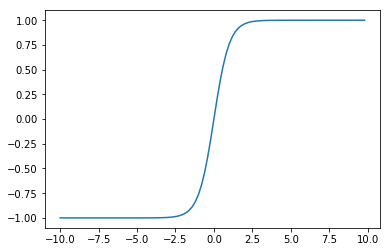

In [40]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three time slices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice:

![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit, the values ($x$) are the input to the unit and the values $c$ are the context values.  Both the output and context values are always fed to the next time slice.  The context values allow 

![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

LSTM is made up of three gates:

* Forget Gate (f_t) - Controls if/when the context is forgotten. (MC)
* Input Gate (i_t) - Controls if/when a value should be remembered by the context. (M+/MS)
* Output Gate (o_t) - Controls if/when the remembered value is allowed to pass from the unit. (RM)

Mathematically, the above diagram can be thought of as the following:

**These are vector values.**

First, calculate the forget gate value.  This gate determines if the short term memory is forgotten.  The value $b$ is a bias, just like the bias neurons we saw before.  Except LSTM has a bias for every gate: $b_t$, $b_i$, and $b_o$.

$$ f_t = S(W_f \cdot [\hat{y}_{t-1}, x_t] + b_f) $$

Next, calculate the input gate value. This gate's value determines what will be remembered.

$$ i_t = S(W_i \cdot [\hat{y}_{t-1},x_t] + b_i) $$

Calculate a candidate context value (a value that might be remembered).  This value is called $\tilde{c}$.

$$ \tilde{C}_t = \tanh(W_C \cdot [\hat{y}_{t-1},x_t]+b_C) $$

Determine the new context ($C_t$).  Do this by remembering the candidate context ($i_t$), depending on input gate.  Forget depending on the forget gate ($f_t$). 

$$ C_t = f_t \cdot C_{t-1}+i_t \cdot \tilde{C}_t $$

Calculate the output gate ($o_t$):

$$ o_t = S(W_o \cdot [\hat{y}_{t-1},x_t] + b_o ) $$

Calculate the actual output ($\hat{y}_t$):

$$ \hat{y}_t = o_t \cdot \tanh(C_t) $$


### Example of one-hot encoder

In [168]:
sess = tf.InteractiveSession()
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
y = np.array([1,2,3,2,3,1],dtype=np.int32)
y = tf.one_hot(y, 4, 1, 0)
y.eval(), tf.convert_to_tensor(x).shape
inputs = tf.unstack(x, num=SEQUENCE_SIZE, axis=1)
tf.convert_to_tensor(inputs).eval()

array([[[0],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [2],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [2],
        [3],
        [0]],

       [[0],
        [2],
        [0],
        [0],
        [3],
        [0]],

       [[0],
        [2],
        [3],
        [0],
        [0],
        [1]],

       [[0],
        [0],
        [3],
        [0],
        [0],
        [1]]], dtype=int32)

# Simple TensorFlow LSTM Example

The following code creates the LSTM network.  This is an example of RNN classification.

In [169]:

import numpy as np
import pandas
import tensorflow as tf
from sklearn import metrics
#from tensorflow.models.rnn import rnn, rnn_cell
import tensorflow.contrib.learn as learn

SEQUENCE_SIZE = 6
HIDDEN_SIZE = 20
NUM_CLASSES = 4

def rnn_classify(X, y):
    # takes y vector of labels, where values represent different classifications(1,2,3,0,1,3).
    # NUM_CLASSES = num of different labels. It has to be the same as unique values in y. 4 clases = [0,1,2,3]
    # new values will be y number of vectors with length of NUM_CLASSES and in this case, 1.0 in the place that 
    # corresponds to the value in the initial y vector. See example above
    y = tf.one_hot(y, NUM_CLASSES, 1, 0) 
    # here we unstack the matrix of X, (which is batch size x SEQUENCE_SIZE) into arrays of individual columns 
    # of that matrix
    inputs = tf.unstack(X, num=SEQUENCE_SIZE, axis=1)

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=HIDDEN_SIZE,state_is_tuple=False)
    _, encoding = tf.contrib.rnn.static_rnn(
        cell=cell, inputs=inputs, dtype=tf.float32)

    logits = tf.contrib.layers.fully_connected(encoding, NUM_CLASSES, activation_fn=None)
    loss = tf.losses.softmax_cross_entropy(y, logits)

    train_op = tf.contrib.layers.optimize_loss(
        loss,
        tf.contrib.framework.get_global_step(),
        optimizer='Adam',
        learning_rate=0.01)

    return ({
                'class': tf.argmax(logits, 1),
                'prob': tf.nn.softmax(logits)
            }, loss, train_op)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('lstm_cls', True)

classifier = learn.Estimator(model_fn=rnn_classify, model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 0, '_is_chief': True, '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_task_type': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f62fda09e10>, '_keep_checkpoint_max': 5, '_model_dir': None, '_task_id': 0, '_evaluation_master': '', '_environment': 'local', '_save_summary_steps': 100, '_master': ''}


The following code trains on a data set (x) with a max sequence size of 6 (columns) and 6 training elements (rows)

In [170]:
%time
tf.logging.set_verbosity(tf.logging.INFO)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

classifier.fit(x, y, steps=1000)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/home/yol/miniconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./dnn/lstm_cls/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.63633
INFO:tensorflow:global_step/sec: 733.883
INFO:tensorflow:step = 101, loss = 0.000620476 (0.137 sec)
INFO:tensorflow:global_step/sec: 869.938
INFO:tensorflow:step = 201, loss = 0.000236307 (0.115 sec)
INFO:tensorflow:global_step/sec: 868.532
INFO:tensorflow:step = 301, loss = 0.000124641 (0.115 sec)
INFO:tensorflow:global_step/sec: 868.314
INFO:tensorflow:step = 401, loss = 7.71039e-05 (0.115 sec)
INFO:tensorflow:global_step/sec: 840.983
INFO:tensorflow:step = 501, loss = 5.26288e-05 (0.119 sec)
INFO:tensorflow:global_step/sec: 836.293
INFO:tensorflow:step = 601, loss = 3.83445e-05 (0.120 sec)
INFO:tensorflow:global_step/sec: 854.608
INFO:tensorflow:step = 701, loss = 2.92454e-05 (0.117 sec)
INFO:tensorflow:global_step/sec: 841.299
INFO:tensorflow:step = 801, loss = 2.31262e-05 (0.119 sec)
INFO:tensorflow:global_step/sec: 899.714
I

Estimator(params=None)

In [174]:
tf.logging.set_verbosity(tf.logging.ERROR)
test = [[[3],[3],[0],[0],[0],[0]]]
test = np.array(test,dtype=np.float32)

pred = list(classifier.predict(test, as_iterable=True))
print(pred[0]['class'])

/home/yol/miniconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


3


In [178]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

print(Y0_val)
print(50*"--")
print(Y1_val)

[[-0.9970063  -0.83448499  0.89556801 -0.99671924 -0.89989704]
 [-0.99999976 -0.99996608  0.99999863 -1.         -1.        ]
 [-1.         -1.          1.         -1.         -1.        ]
 [-0.9897722  -0.999937    0.99991792 -0.99999928 -1.        ]]
----------------------------------------------------------------------------------------------------
[[-1.         -1.          1.         -1.         -1.        ]
 [-0.40291983 -0.8556965  -0.7910403  -0.93776017  0.95572329]
 [-0.99999928 -0.99999982  0.99999994 -1.         -1.        ]
 [-0.97875482 -0.99966657  0.99592251 -0.99999833 -0.99999881]]


# Stock Market Example

An example of RNN regression.

In [2]:
# How to read data from the stock market.
from IPython.display import display, HTML
from pandas_datareader import data, wb
import datetime

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2014, 12, 31)

# Get a quote for tsla from Yahoo service
f=data.DataReader('tsla', 'yahoo', start, end)
display(f)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,149.800003,152.479996,146.550003,150.100006,6188400,150.100006
2014-01-03,150.000000,152.190002,148.600006,149.559998,4695000,149.559998
2014-01-06,150.000000,150.399994,145.240005,147.000000,5361100,147.000000
2014-01-07,147.619995,150.399994,145.250000,149.360001,5034100,149.360001
2014-01-08,148.850006,153.699997,148.759995,151.279999,6163200,151.279999
2014-01-09,152.500000,153.429993,146.850006,147.529999,5382000,147.529999
2014-01-10,148.460007,148.899994,142.250000,145.720001,7446100,145.720001
2014-01-13,145.779999,147.000000,137.820007,139.339996,6316100,139.339996
2014-01-14,140.500000,162.000000,136.669998,161.270004,27607000,161.270004


In [3]:
import numpy as np
prices = f.Close.pct_change().tolist() # to percent changes
prices = prices[1:] # skip the first, no percent change


SEQUENCE_SIZE = 5
x = []
y = []

for i in range(len(prices)-SEQUENCE_SIZE-1):
    #print(i)
    window = prices[i:(i+SEQUENCE_SIZE)]
    after_window = prices[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
    y.append(after_window)
    
x = np.array(x)
print(len(x))
    

245


In [122]:
import tensorflow as tf
import tensorflow.contrib.learn as learn

HIDDEN_SIZE = 20

def rnn_regression(X, y):
    #Fix issue fith float64 in tf
    X = tf.cast(X,tf.float32)
    #unpack is replaced by unstack in tf
    inputs = tf.unstack(X, num=SEQUENCE_SIZE, axis=1)
    #inputs = tf.unpack(X, num=SEQUENCE_SIZE, axis=1)

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=HIDDEN_SIZE,state_is_tuple =False)
    _, encoding = tf.contrib.rnn.static_rnn(cell=cell, inputs=inputs, dtype=tf.float32)

    output = tf.contrib.layers.fully_connected(encoding, 1, activation_fn=None)
    
    optimizer = "Adam"
    prediction, loss = learn.models.linear_regression(output, y)
    train_op = tf.contrib.layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(), optimizer=optimizer,
            learning_rate=0.1)
    return prediction, loss, train_op

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('lstm_reg', True)

regressor = learn.Estimator(model_fn=rnn_regression, model_dir=model_dir)

regressor.fit(x, y)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 0, '_is_chief': True, '_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_task_type': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6322738208>, '_keep_checkpoint_max': 5, '_model_dir': None, '_task_id': 0, '_evaluation_master': '', '_environment': 'local', '_save_summary_steps': 100, '_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving 

/home/yol/miniconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./dnn/lstm_reg/model.ckpt.
INFO:tensorflow:step = 1, loss = 10.0758
INFO:tensorflow:global_step/sec: 607.704
INFO:tensorflow:step = 101, loss = 3.26345e-05 (0.165 sec)
INFO:tensorflow:global_step/sec: 841.741
INFO:tensorflow:step = 201, loss = 1.22619e-09 (0.119 sec)
INFO:tensorflow:global_step/sec: 810.072
INFO:tensorflow:step = 301, loss = 2.36848e-14 (0.124 sec)
INFO:tensorflow:global_step/sec: 840.651
INFO:tensorflow:step = 401, loss = 1.18424e-14 (0.119 sec)
INFO:tensorflow:global_step/sec: 845.742
INFO:tensorflow:step = 501, loss = 5.92119e-16 (0.118 sec)
INFO:tensorflow:global_step/sec: 795.16

INFO:tensorflow:step = 7201, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 805.186
INFO:tensorflow:step = 7301, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 821.568
INFO:tensorflow:step = 7401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 791.442
INFO:tensorflow:step = 7501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 853.108
INFO:tensorflow:step = 7601, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 837.532
INFO:tensorflow:step = 7701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 859.948
INFO:tensorflow:step = 7801, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 852.258
INFO:tensorflow:step = 7901, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 809.377
INFO:tensorflow:step = 8001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 824.158
INFO:tensorflow:step = 8101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 848.411
INFO:tensorflow:step = 8201, loss = 0.0 (0.118 sec)
INFO:tensorflow:gl

INFO:tensorflow:step = 16001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.046
INFO:tensorflow:step = 16101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 792.612
INFO:tensorflow:step = 16201, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 833.982
INFO:tensorflow:step = 16301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 826.033
INFO:tensorflow:step = 16401, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 888.563
INFO:tensorflow:step = 16501, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 819.166
INFO:tensorflow:step = 16601, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 849.196
INFO:tensorflow:step = 16701, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 874.549
INFO:tensorflow:step = 16801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 892.297
INFO:tensorflow:step = 16901, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 879.89
INFO:tensorflow:step = 17001, loss = 0.0 (0.114 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 853.688
INFO:tensorflow:step = 24801, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 818.995
INFO:tensorflow:step = 24901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 797.739
INFO:tensorflow:step = 25001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 795.586
INFO:tensorflow:step = 25101, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 862.766
INFO:tensorflow:step = 25201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 862.513
INFO:tensorflow:step = 25301, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 848.526
INFO:tensorflow:step = 25401, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 836.639
INFO:tensorflow:step = 25501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 843.451
INFO:tensorflow:step = 25601, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 861.692
INFO:tensorflow:step = 25701, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 865.39
INFO:tensorflow:step

INFO:tensorflow:step = 33501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 796.342
INFO:tensorflow:step = 33601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 795.172
INFO:tensorflow:step = 33701, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 866.336
INFO:tensorflow:step = 33801, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 869.378
INFO:tensorflow:step = 33901, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 880.688
INFO:tensorflow:step = 34001, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 857.116
INFO:tensorflow:step = 34101, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 870.422
INFO:tensorflow:step = 34201, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 877.29
INFO:tensorflow:step = 34301, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 815.123
INFO:tensorflow:step = 34401, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 872.461
INFO:tensorflow:step = 34501, loss = 0.0 (0.115 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 831.158
INFO:tensorflow:step = 42301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 839.351
INFO:tensorflow:step = 42401, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 809.327
INFO:tensorflow:step = 42501, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 805.553
INFO:tensorflow:step = 42601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 860.582
INFO:tensorflow:step = 42701, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 810.141
INFO:tensorflow:step = 42801, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 813.105
INFO:tensorflow:step = 42901, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 854.615
INFO:tensorflow:step = 43001, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 864.98
INFO:tensorflow:step = 43101, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 885.869
INFO:tensorflow:step = 43201, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 821.084
INFO:tensorflow:step

INFO:tensorflow:step = 51001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 826.799
INFO:tensorflow:step = 51101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 793.551
INFO:tensorflow:step = 51201, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 791.986
INFO:tensorflow:step = 51301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 801.943
INFO:tensorflow:step = 51401, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 855.937
INFO:tensorflow:step = 51501, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 868.839
INFO:tensorflow:step = 51601, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 861.154
INFO:tensorflow:step = 51701, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 876.194
INFO:tensorflow:step = 51801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 867.491
INFO:tensorflow:step = 51901, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 841.297
INFO:tensorflow:step = 52001, loss = 0.0 (0.119 sec)
INFO:te

INFO:tensorflow:global_step/sec: 865.58
INFO:tensorflow:step = 59801, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 856.559
INFO:tensorflow:step = 59901, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 773.878
INFO:tensorflow:step = 60001, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 802.756
INFO:tensorflow:step = 60101, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 835.015
INFO:tensorflow:step = 60201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 782.557
INFO:tensorflow:step = 60301, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 790.838
INFO:tensorflow:step = 60401, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 815.454
INFO:tensorflow:step = 60501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 808.848
INFO:tensorflow:step = 60601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 823.727
INFO:tensorflow:step = 60701, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 782.217
INFO:tensorflow:step

INFO:tensorflow:step = 68501, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 766.298
INFO:tensorflow:step = 68601, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 864.046
INFO:tensorflow:step = 68701, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 829.038
INFO:tensorflow:step = 68801, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 803.79
INFO:tensorflow:step = 68901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 844.188
INFO:tensorflow:step = 69001, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 900.396
INFO:tensorflow:step = 69101, loss = 0.0 (0.111 sec)
INFO:tensorflow:global_step/sec: 822.48
INFO:tensorflow:step = 69201, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 814.191
INFO:tensorflow:step = 69301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 862.043
INFO:tensorflow:step = 69401, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 823.774
INFO:tensorflow:step = 69501, loss = 0.0 (0.121 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 831.924
INFO:tensorflow:step = 77301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 827.937
INFO:tensorflow:step = 77401, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 828.23
INFO:tensorflow:step = 77501, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 831.171
INFO:tensorflow:step = 77601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 839.529
INFO:tensorflow:step = 77701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 828.796
INFO:tensorflow:step = 77801, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 837.698
INFO:tensorflow:step = 77901, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 833.856
INFO:tensorflow:step = 78001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 808.145
INFO:tensorflow:step = 78101, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 763.092
INFO:tensorflow:step = 78201, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 773.915
INFO:tensorflow:step

INFO:tensorflow:step = 86001, loss = 0.0 (0.146 sec)
INFO:tensorflow:global_step/sec: 697.698
INFO:tensorflow:step = 86101, loss = 0.0 (0.143 sec)
INFO:tensorflow:global_step/sec: 678.509
INFO:tensorflow:step = 86201, loss = 0.0 (0.147 sec)
INFO:tensorflow:global_step/sec: 739.972
INFO:tensorflow:step = 86301, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 685.693
INFO:tensorflow:step = 86401, loss = 0.0 (0.146 sec)
INFO:tensorflow:global_step/sec: 779.403
INFO:tensorflow:step = 86501, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 827.968
INFO:tensorflow:step = 86601, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 824.808
INFO:tensorflow:step = 86701, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 832.879
INFO:tensorflow:step = 86801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.157
INFO:tensorflow:step = 86901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 829.658
INFO:tensorflow:step = 87001, loss = 0.0 (0.121 sec)
INFO:te

INFO:tensorflow:global_step/sec: 741.824
INFO:tensorflow:step = 94801, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 690.022
INFO:tensorflow:step = 94901, loss = 0.0 (0.146 sec)
INFO:tensorflow:global_step/sec: 823.591
INFO:tensorflow:step = 95001, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 828.503
INFO:tensorflow:step = 95101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 833.306
INFO:tensorflow:step = 95201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.602
INFO:tensorflow:step = 95301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 784.865
INFO:tensorflow:step = 95401, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 842.817
INFO:tensorflow:step = 95501, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 749.075
INFO:tensorflow:step = 95601, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 722.409
INFO:tensorflow:step = 95701, loss = 0.0 (0.138 sec)
INFO:tensorflow:global_step/sec: 821.77
INFO:tensorflow:step

INFO:tensorflow:global_step/sec: 839.48
INFO:tensorflow:step = 103501, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 781.167
INFO:tensorflow:step = 103601, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 668.029
INFO:tensorflow:step = 103701, loss = 0.0 (0.149 sec)
INFO:tensorflow:global_step/sec: 745.695
INFO:tensorflow:step = 103801, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 744.329
INFO:tensorflow:step = 103901, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 677.976
INFO:tensorflow:step = 104001, loss = 0.0 (0.148 sec)
INFO:tensorflow:global_step/sec: 793.044
INFO:tensorflow:step = 104101, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 827.166
INFO:tensorflow:step = 104201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 827.377
INFO:tensorflow:step = 104301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 819.376
INFO:tensorflow:step = 104401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 806.034
INFO:tenso

INFO:tensorflow:step = 112101, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 824.096
INFO:tensorflow:step = 112201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 797.69
INFO:tensorflow:step = 112301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 882.699
INFO:tensorflow:step = 112401, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 870.603
INFO:tensorflow:step = 112501, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 839.971
INFO:tensorflow:step = 112601, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 856.632
INFO:tensorflow:step = 112701, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 894.041
INFO:tensorflow:step = 112801, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 890.845
INFO:tensorflow:step = 112901, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 835.377
INFO:tensorflow:step = 113001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 862.768
INFO:tensorflow:step = 113101, loss = 0.0 (0.116 se

INFO:tensorflow:global_step/sec: 836.265
INFO:tensorflow:step = 120801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.665
INFO:tensorflow:step = 120901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.932
INFO:tensorflow:step = 121001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.783
INFO:tensorflow:step = 121101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 828.23
INFO:tensorflow:step = 121201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 836.263
INFO:tensorflow:step = 121301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.575
INFO:tensorflow:step = 121401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 841.398
INFO:tensorflow:step = 121501, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 836.831
INFO:tensorflow:step = 121601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.106
INFO:tensorflow:step = 121701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.236
INFO:tenso

INFO:tensorflow:step = 129401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.808
INFO:tensorflow:step = 129501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.53
INFO:tensorflow:step = 129601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 837.772
INFO:tensorflow:step = 129701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 832.139
INFO:tensorflow:step = 129801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.583
INFO:tensorflow:step = 129901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.691
INFO:tensorflow:step = 130001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 827.315
INFO:tensorflow:step = 130101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 828.179
INFO:tensorflow:step = 130201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 834.795
INFO:tensorflow:step = 130301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.397
INFO:tensorflow:step = 130401, loss = 0.0 (0.119 se

INFO:tensorflow:global_step/sec: 920.947
INFO:tensorflow:step = 138101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.534
INFO:tensorflow:step = 138201, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.63
INFO:tensorflow:step = 138301, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.076
INFO:tensorflow:step = 138401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 921.959
INFO:tensorflow:step = 138501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 924.318
INFO:tensorflow:step = 138601, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.187
INFO:tensorflow:step = 138701, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 922.778
INFO:tensorflow:step = 138801, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 920.595
INFO:tensorflow:step = 138901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.69
INFO:tensorflow:step = 139001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 915.689
INFO:tensor

INFO:tensorflow:step = 146701, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.739
INFO:tensorflow:step = 146801, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.799
INFO:tensorflow:step = 146901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.971
INFO:tensorflow:step = 147001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 921.133
INFO:tensorflow:step = 147101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.552
INFO:tensorflow:step = 147201, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.618
INFO:tensorflow:step = 147301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 917.6
INFO:tensorflow:step = 147401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 924.114
INFO:tensorflow:step = 147501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 920.916
INFO:tensorflow:step = 147601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 924.163
INFO:tensorflow:step = 147701, loss = 0.0 (0.108 sec

INFO:tensorflow:global_step/sec: 924.968
INFO:tensorflow:step = 155401, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 916.561
INFO:tensorflow:step = 155501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 910.517
INFO:tensorflow:step = 155601, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 921.979
INFO:tensorflow:step = 155701, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 918.412
INFO:tensorflow:step = 155801, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 921.461
INFO:tensorflow:step = 155901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 916.487
INFO:tensorflow:step = 156001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 921.232
INFO:tensorflow:step = 156101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 916.309
INFO:tensorflow:step = 156201, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.587
INFO:tensorflow:step = 156301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 858.44
INFO:tenso

INFO:tensorflow:step = 164001, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 807.024
INFO:tensorflow:step = 164101, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 797.857
INFO:tensorflow:step = 164201, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 796.727
INFO:tensorflow:step = 164301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 862.642
INFO:tensorflow:step = 164401, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 848.635
INFO:tensorflow:step = 164501, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 814.654
INFO:tensorflow:step = 164601, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 826.488
INFO:tensorflow:step = 164701, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 830.402
INFO:tensorflow:step = 164801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 780.283
INFO:tensorflow:step = 164901, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 804.277
INFO:tensorflow:step = 165001, loss = 0.0 (0.124 s

INFO:tensorflow:global_step/sec: 841.898
INFO:tensorflow:step = 172701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 797.71
INFO:tensorflow:step = 172801, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 810.898
INFO:tensorflow:step = 172901, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 850.549
INFO:tensorflow:step = 173001, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 888.039
INFO:tensorflow:step = 173101, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 864.675
INFO:tensorflow:step = 173201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 877.387
INFO:tensorflow:step = 173301, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 849.631
INFO:tensorflow:step = 173401, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 850.936
INFO:tensorflow:step = 173501, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 843.644
INFO:tensorflow:step = 173601, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 861.832
INFO:tenso

INFO:tensorflow:step = 181301, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 836.467
INFO:tensorflow:step = 181401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 816.68
INFO:tensorflow:step = 181501, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 808.874
INFO:tensorflow:step = 181601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 827.134
INFO:tensorflow:step = 181701, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 845.764
INFO:tensorflow:step = 181801, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 793.561
INFO:tensorflow:step = 181901, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 862.108
INFO:tensorflow:step = 182001, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 878.78
INFO:tensorflow:step = 182101, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 821.284
INFO:tensorflow:step = 182201, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 861.17
INFO:tensorflow:step = 182301, loss = 0.0 (0.116 sec)

INFO:tensorflow:global_step/sec: 838.246
INFO:tensorflow:step = 190001, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 840.18
INFO:tensorflow:step = 190101, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 814.05
INFO:tensorflow:step = 190201, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 779.457
INFO:tensorflow:step = 190301, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 858.238
INFO:tensorflow:step = 190401, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 888.509
INFO:tensorflow:step = 190501, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 889.577
INFO:tensorflow:step = 190601, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 844.626
INFO:tensorflow:step = 190701, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 888.918
INFO:tensorflow:step = 190801, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 887.208
INFO:tensorflow:step = 190901, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 802.321
INFO:tensor

INFO:tensorflow:step = 198601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 840.139
INFO:tensorflow:step = 198701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 887.586
INFO:tensorflow:step = 198801, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 819.374
INFO:tensorflow:step = 198901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 805.78
INFO:tensorflow:step = 199001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 864.08
INFO:tensorflow:step = 199101, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 876.17
INFO:tensorflow:step = 199201, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 804.751
INFO:tensorflow:step = 199301, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 777.456
INFO:tensorflow:step = 199401, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 792.916
INFO:tensorflow:step = 199501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 783.84
INFO:tensorflow:step = 199601, loss = 0.0 (0.128 sec)


INFO:tensorflow:global_step/sec: 845.921
INFO:tensorflow:step = 207301, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 878.718
INFO:tensorflow:step = 207401, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 810.713
INFO:tensorflow:step = 207501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 798.155
INFO:tensorflow:step = 207601, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 863.994
INFO:tensorflow:step = 207701, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 814.722
INFO:tensorflow:step = 207801, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 849.409
INFO:tensorflow:step = 207901, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 879.473
INFO:tensorflow:step = 208001, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 872.61
INFO:tensorflow:step = 208101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 890.896
INFO:tensorflow:step = 208201, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 855.031
INFO:tenso

INFO:tensorflow:step = 215901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 808.837
INFO:tensorflow:step = 216001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 839.854
INFO:tensorflow:step = 216101, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 800.984
INFO:tensorflow:step = 216201, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 842.487
INFO:tensorflow:step = 216301, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 798.279
INFO:tensorflow:step = 216401, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 788.741
INFO:tensorflow:step = 216501, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 862.33
INFO:tensorflow:step = 216601, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 873.149
INFO:tensorflow:step = 216701, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 809.221
INFO:tensorflow:step = 216801, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 824.145
INFO:tensorflow:step = 216901, loss = 0.0 (0.121 se

INFO:tensorflow:global_step/sec: 820.405
INFO:tensorflow:step = 224601, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 800.078
INFO:tensorflow:step = 224701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 797.055
INFO:tensorflow:step = 224801, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 806.951
INFO:tensorflow:step = 224901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 808.416
INFO:tensorflow:step = 225001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 822.074
INFO:tensorflow:step = 225101, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 871.779
INFO:tensorflow:step = 225201, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 878.751
INFO:tensorflow:step = 225301, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 803.899
INFO:tensorflow:step = 225401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 871.348
INFO:tensorflow:step = 225501, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 825.058
INFO:tens

INFO:tensorflow:step = 233201, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 794.511
INFO:tensorflow:step = 233301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 792.609
INFO:tensorflow:step = 233401, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 794.272
INFO:tensorflow:step = 233501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 826.365
INFO:tensorflow:step = 233601, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 876.811
INFO:tensorflow:step = 233701, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 847.51
INFO:tensorflow:step = 233801, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 865.537
INFO:tensorflow:step = 233901, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 862.451
INFO:tensorflow:step = 234001, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 781.93
INFO:tensorflow:step = 234101, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 867.675
INFO:tensorflow:step = 234201, loss = 0.0 (0.115 sec

INFO:tensorflow:global_step/sec: 840.431
INFO:tensorflow:step = 241901, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 802.696
INFO:tensorflow:step = 242001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 806.279
INFO:tensorflow:step = 242101, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 859.082
INFO:tensorflow:step = 242201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 812.738
INFO:tensorflow:step = 242301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 841.068
INFO:tensorflow:step = 242401, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 823.027
INFO:tensorflow:step = 242501, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 859.931
INFO:tensorflow:step = 242601, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 857.698
INFO:tensorflow:step = 242701, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 874.498
INFO:tensorflow:step = 242801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 874.353
INFO:tens

INFO:tensorflow:step = 250501, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 849.364
INFO:tensorflow:step = 250601, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 806.881
INFO:tensorflow:step = 250701, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 832.977
INFO:tensorflow:step = 250801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 800.502
INFO:tensorflow:step = 250901, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 788.608
INFO:tensorflow:step = 251001, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 840.002
INFO:tensorflow:step = 251101, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 782.594
INFO:tensorflow:step = 251201, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 771.629
INFO:tensorflow:step = 251301, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 733.777
INFO:tensorflow:step = 251401, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 780.183
INFO:tensorflow:step = 251501, loss = 0.0 (0.128 s

INFO:tensorflow:global_step/sec: 867.825
INFO:tensorflow:step = 259201, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 829.088
INFO:tensorflow:step = 259301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 808.826
INFO:tensorflow:step = 259401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 853.658
INFO:tensorflow:step = 259501, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 889.049
INFO:tensorflow:step = 259601, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 893.268
INFO:tensorflow:step = 259701, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 875.186
INFO:tensorflow:step = 259801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 846.674
INFO:tensorflow:step = 259901, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 860.568
INFO:tensorflow:step = 260001, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 866.653
INFO:tensorflow:step = 260101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 868.656
INFO:tens

INFO:tensorflow:step = 267801, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 892.244
INFO:tensorflow:step = 267901, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 868.616
INFO:tensorflow:step = 268001, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 866.175
INFO:tensorflow:step = 268101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 845.392
INFO:tensorflow:step = 268201, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 821.258
INFO:tensorflow:step = 268301, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 784.236
INFO:tensorflow:step = 268401, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 821.432
INFO:tensorflow:step = 268501, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 888.85
INFO:tensorflow:step = 268601, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 868.381
INFO:tensorflow:step = 268701, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 859.633
INFO:tensorflow:step = 268801, loss = 0.0 (0.116 se

INFO:tensorflow:global_step/sec: 704.085
INFO:tensorflow:step = 276501, loss = 0.0 (0.142 sec)
INFO:tensorflow:global_step/sec: 706.011
INFO:tensorflow:step = 276601, loss = 0.0 (0.142 sec)
INFO:tensorflow:global_step/sec: 660.481
INFO:tensorflow:step = 276701, loss = 0.0 (0.151 sec)
INFO:tensorflow:global_step/sec: 783.543
INFO:tensorflow:step = 276801, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 800.759
INFO:tensorflow:step = 276901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 694.202
INFO:tensorflow:step = 277001, loss = 0.0 (0.144 sec)
INFO:tensorflow:global_step/sec: 674.362
INFO:tensorflow:step = 277101, loss = 0.0 (0.148 sec)
INFO:tensorflow:global_step/sec: 724.56
INFO:tensorflow:step = 277201, loss = 0.0 (0.138 sec)
INFO:tensorflow:global_step/sec: 807.226
INFO:tensorflow:step = 277301, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 778.355
INFO:tensorflow:step = 277401, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 798.184
INFO:tenso

INFO:tensorflow:step = 285101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.381
INFO:tensorflow:step = 285201, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.184
INFO:tensorflow:step = 285301, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 920.458
INFO:tensorflow:step = 285401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 926.2
INFO:tensorflow:step = 285501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 919.664
INFO:tensorflow:step = 285601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.03
INFO:tensorflow:step = 285701, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.555
INFO:tensorflow:step = 285801, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.064
INFO:tensorflow:step = 285901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 914.124
INFO:tensorflow:step = 286001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 888.643
INFO:tensorflow:step = 286101, loss = 0.0 (0.113 sec)

INFO:tensorflow:global_step/sec: 811.844
INFO:tensorflow:step = 293801, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 827.705
INFO:tensorflow:step = 293901, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 835.898
INFO:tensorflow:step = 294001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.937
INFO:tensorflow:step = 294101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 798.906
INFO:tensorflow:step = 294201, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 831.209
INFO:tensorflow:step = 294301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.786
INFO:tensorflow:step = 294401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 829.44
INFO:tensorflow:step = 294501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 857.519
INFO:tensorflow:step = 294601, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 927.677
INFO:tensorflow:step = 294701, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.91
INFO:tensor

INFO:tensorflow:step = 302401, loss = 0.0 (0.142 sec)
INFO:tensorflow:global_step/sec: 772.837
INFO:tensorflow:step = 302501, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 831.09
INFO:tensorflow:step = 302601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.916
INFO:tensorflow:step = 302701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 827.573
INFO:tensorflow:step = 302801, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 803.728
INFO:tensorflow:step = 302901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 713.432
INFO:tensorflow:step = 303001, loss = 0.0 (0.140 sec)
INFO:tensorflow:global_step/sec: 767.066
INFO:tensorflow:step = 303101, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 833.289
INFO:tensorflow:step = 303201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.855
INFO:tensorflow:step = 303301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 827.48
INFO:tensorflow:step = 303401, loss = 0.0 (0.121 sec

INFO:tensorflow:global_step/sec: 922.815
INFO:tensorflow:step = 311101, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.115
INFO:tensorflow:step = 311201, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 917.602
INFO:tensorflow:step = 311301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 917.594
INFO:tensorflow:step = 311401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 928.578
INFO:tensorflow:step = 311501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 910.643
INFO:tensorflow:step = 311601, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 907.886
INFO:tensorflow:step = 311701, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 898.105
INFO:tensorflow:step = 311801, loss = 0.0 (0.111 sec)
INFO:tensorflow:global_step/sec: 902.504
INFO:tensorflow:step = 311901, loss = 0.0 (0.111 sec)
INFO:tensorflow:global_step/sec: 889.568
INFO:tensorflow:step = 312001, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 895.383
INFO:tens

INFO:tensorflow:step = 319701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.646
INFO:tensorflow:step = 319801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 816.925
INFO:tensorflow:step = 319901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 831.344
INFO:tensorflow:step = 320001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 813.01
INFO:tensorflow:step = 320101, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 832.644
INFO:tensorflow:step = 320201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.309
INFO:tensorflow:step = 320301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 828.604
INFO:tensorflow:step = 320401, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 810.942
INFO:tensorflow:step = 320501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 831.782
INFO:tensorflow:step = 320601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.458
INFO:tensorflow:step = 320701, loss = 0.0 (0.120 se

INFO:tensorflow:global_step/sec: 920.639
INFO:tensorflow:step = 328401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 922.51
INFO:tensorflow:step = 328501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.236
INFO:tensorflow:step = 328601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 819.94
INFO:tensorflow:step = 328701, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 831.692
INFO:tensorflow:step = 328801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.949
INFO:tensorflow:step = 328901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 822.924
INFO:tensorflow:step = 329001, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 819.379
INFO:tensorflow:step = 329101, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 816.454
INFO:tensorflow:step = 329201, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 840.581
INFO:tensorflow:step = 329301, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 832.405
INFO:tensor

INFO:tensorflow:step = 337001, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 749.56
INFO:tensorflow:step = 337101, loss = 0.0 (0.133 sec)
INFO:tensorflow:global_step/sec: 793.438
INFO:tensorflow:step = 337201, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 832.848
INFO:tensorflow:step = 337301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 786.343
INFO:tensorflow:step = 337401, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 782.737
INFO:tensorflow:step = 337501, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 769.735
INFO:tensorflow:step = 337601, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 744.551
INFO:tensorflow:step = 337701, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 759.477
INFO:tensorflow:step = 337801, loss = 0.0 (0.132 sec)
INFO:tensorflow:global_step/sec: 803.07
INFO:tensorflow:step = 337901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 830.46
INFO:tensorflow:step = 338001, loss = 0.0 (0.120 sec)

INFO:tensorflow:global_step/sec: 911.603
INFO:tensorflow:step = 345701, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 917.925
INFO:tensorflow:step = 345801, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 917.458
INFO:tensorflow:step = 345901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.497
INFO:tensorflow:step = 346001, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 915.821
INFO:tensorflow:step = 346101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.387
INFO:tensorflow:step = 346201, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.902
INFO:tensorflow:step = 346301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.495
INFO:tensorflow:step = 346401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.757
INFO:tensorflow:step = 346501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 913.525
INFO:tensorflow:step = 346601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 916.147
INFO:tens

INFO:tensorflow:step = 354301, loss = 0.0 (0.111 sec)
INFO:tensorflow:global_step/sec: 918.728
INFO:tensorflow:step = 354401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 916.738
INFO:tensorflow:step = 354501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.541
INFO:tensorflow:step = 354601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 912.716
INFO:tensorflow:step = 354701, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 923.679
INFO:tensorflow:step = 354801, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 915.004
INFO:tensorflow:step = 354901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 921.432
INFO:tensorflow:step = 355001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.461
INFO:tensorflow:step = 355101, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 914.589
INFO:tensorflow:step = 355201, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.466
INFO:tensorflow:step = 355301, loss = 0.0 (0.109 s

INFO:tensorflow:global_step/sec: 799.858
INFO:tensorflow:step = 363001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 800.443
INFO:tensorflow:step = 363101, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 803.802
INFO:tensorflow:step = 363201, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 800.788
INFO:tensorflow:step = 363301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 806.375
INFO:tensorflow:step = 363401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 795.421
INFO:tensorflow:step = 363501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 732.393
INFO:tensorflow:step = 363601, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 700.681
INFO:tensorflow:step = 363701, loss = 0.0 (0.143 sec)
INFO:tensorflow:global_step/sec: 733.116
INFO:tensorflow:step = 363801, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 747.894
INFO:tensorflow:step = 363901, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 798.324
INFO:tens

INFO:tensorflow:step = 371601, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.631
INFO:tensorflow:step = 371701, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 918.895
INFO:tensorflow:step = 371801, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 918.217
INFO:tensorflow:step = 371901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 918.86
INFO:tensorflow:step = 372001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 888.899
INFO:tensorflow:step = 372101, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 878.521
INFO:tensorflow:step = 372201, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 916.065
INFO:tensorflow:step = 372301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 918.048
INFO:tensorflow:step = 372401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 922.896
INFO:tensorflow:step = 372501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.319
INFO:tensorflow:step = 372601, loss = 0.0 (0.109 se

INFO:tensorflow:global_step/sec: 913.822
INFO:tensorflow:step = 380301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 922.612
INFO:tensorflow:step = 380401, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 917.271
INFO:tensorflow:step = 380501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 790.904
INFO:tensorflow:step = 380601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 806.062
INFO:tensorflow:step = 380701, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 793.16
INFO:tensorflow:step = 380801, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 746.813
INFO:tensorflow:step = 380901, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 779.36
INFO:tensorflow:step = 381001, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 820.188
INFO:tensorflow:step = 381101, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 827.223
INFO:tensorflow:step = 381201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 838.23
INFO:tensorf

INFO:tensorflow:step = 388901, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 655.818
INFO:tensorflow:step = 389001, loss = 0.0 (0.153 sec)
INFO:tensorflow:global_step/sec: 721.632
INFO:tensorflow:step = 389101, loss = 0.0 (0.138 sec)
INFO:tensorflow:global_step/sec: 833.129
INFO:tensorflow:step = 389201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 815.467
INFO:tensorflow:step = 389301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 788.434
INFO:tensorflow:step = 389401, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 854.294
INFO:tensorflow:step = 389501, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 904.854
INFO:tensorflow:step = 389601, loss = 0.0 (0.111 sec)
INFO:tensorflow:global_step/sec: 916.127
INFO:tensorflow:step = 389701, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 909.271
INFO:tensorflow:step = 389801, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 915.717
INFO:tensorflow:step = 389901, loss = 0.0 (0.109 s

INFO:tensorflow:global_step/sec: 909.182
INFO:tensorflow:step = 397601, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 780.169
INFO:tensorflow:step = 397701, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 779.143
INFO:tensorflow:step = 397801, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 757.54
INFO:tensorflow:step = 397901, loss = 0.0 (0.132 sec)
INFO:tensorflow:global_step/sec: 763.848
INFO:tensorflow:step = 398001, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 759.611
INFO:tensorflow:step = 398101, loss = 0.0 (0.132 sec)
INFO:tensorflow:global_step/sec: 762.285
INFO:tensorflow:step = 398201, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 812.412
INFO:tensorflow:step = 398301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 835.93
INFO:tensorflow:step = 398401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.415
INFO:tensorflow:step = 398501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 766.128
INFO:tensor

INFO:tensorflow:step = 406201, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 921.981
INFO:tensorflow:step = 406301, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.829
INFO:tensorflow:step = 406401, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 924.489
INFO:tensorflow:step = 406501, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 910.252
INFO:tensorflow:step = 406601, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 846.054
INFO:tensorflow:step = 406701, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 832.433
INFO:tensorflow:step = 406801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.927
INFO:tensorflow:step = 406901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.479
INFO:tensorflow:step = 407001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.189
INFO:tensorflow:step = 407101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.497
INFO:tensorflow:step = 407201, loss = 0.0 (0.120 s

INFO:tensorflow:global_step/sec: 925.28
INFO:tensorflow:step = 414901, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 919.925
INFO:tensorflow:step = 415001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 925.282
INFO:tensorflow:step = 415101, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 920.87
INFO:tensorflow:step = 415201, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 925.064
INFO:tensorflow:step = 415301, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 918.794
INFO:tensorflow:step = 415401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.711
INFO:tensorflow:step = 415501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 924.899
INFO:tensorflow:step = 415601, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.502
INFO:tensorflow:step = 415701, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 922.926
INFO:tensorflow:step = 415801, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 926.324
INFO:tensor

INFO:tensorflow:step = 423501, loss = 0.0 (0.136 sec)
INFO:tensorflow:global_step/sec: 740.999
INFO:tensorflow:step = 423601, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 687.907
INFO:tensorflow:step = 423701, loss = 0.0 (0.145 sec)
INFO:tensorflow:global_step/sec: 723.393
INFO:tensorflow:step = 423801, loss = 0.0 (0.138 sec)
INFO:tensorflow:global_step/sec: 734.159
INFO:tensorflow:step = 423901, loss = 0.0 (0.136 sec)
INFO:tensorflow:global_step/sec: 786.309
INFO:tensorflow:step = 424001, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 792.179
INFO:tensorflow:step = 424101, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 805.825
INFO:tensorflow:step = 424201, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 799.594
INFO:tensorflow:step = 424301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 808.489
INFO:tensorflow:step = 424401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 812.494
INFO:tensorflow:step = 424501, loss = 0.0 (0.123 s

INFO:tensorflow:global_step/sec: 825.78
INFO:tensorflow:step = 432201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 829.073
INFO:tensorflow:step = 432301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 835.738
INFO:tensorflow:step = 432401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.495
INFO:tensorflow:step = 432501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.307
INFO:tensorflow:step = 432601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 839.262
INFO:tensorflow:step = 432701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 835.332
INFO:tensorflow:step = 432801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.47
INFO:tensorflow:step = 432901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 838.748
INFO:tensorflow:step = 433001, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 833.646
INFO:tensorflow:step = 433101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 828.267
INFO:tensor

INFO:tensorflow:step = 440801, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 793.192
INFO:tensorflow:step = 440901, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 797.317
INFO:tensorflow:step = 441001, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 787.589
INFO:tensorflow:step = 441101, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 827.774
INFO:tensorflow:step = 441201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 823.189
INFO:tensorflow:step = 441301, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 821.881
INFO:tensorflow:step = 441401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 835.144
INFO:tensorflow:step = 441501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 853.467
INFO:tensorflow:step = 441601, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 832.639
INFO:tensorflow:step = 441701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.022
INFO:tensorflow:step = 441801, loss = 0.0 (0.120 s

INFO:tensorflow:global_step/sec: 852.331
INFO:tensorflow:step = 449501, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 884.024
INFO:tensorflow:step = 449601, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 794.775
INFO:tensorflow:step = 449701, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 819.034
INFO:tensorflow:step = 449801, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 806.247
INFO:tensorflow:step = 449901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 851.468
INFO:tensorflow:step = 450001, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 789.406
INFO:tensorflow:step = 450101, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 782.147
INFO:tensorflow:step = 450201, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 853.538
INFO:tensorflow:step = 450301, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 844.317
INFO:tensorflow:step = 450401, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 858.005
INFO:tens

INFO:tensorflow:step = 458101, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 731.1
INFO:tensorflow:step = 458201, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 742.815
INFO:tensorflow:step = 458301, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 785.528
INFO:tensorflow:step = 458401, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 811.627
INFO:tensorflow:step = 458501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 772.873
INFO:tensorflow:step = 458601, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 804.871
INFO:tensorflow:step = 458701, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 807.734
INFO:tensorflow:step = 458801, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 857.617
INFO:tensorflow:step = 458901, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 788.32
INFO:tensorflow:step = 459001, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 732.416
INFO:tensorflow:step = 459101, loss = 0.0 (0.136 sec)

INFO:tensorflow:global_step/sec: 887.999
INFO:tensorflow:step = 466801, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 831.388
INFO:tensorflow:step = 466901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 824.701
INFO:tensorflow:step = 467001, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 825.035
INFO:tensorflow:step = 467101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 811.274
INFO:tensorflow:step = 467201, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 801.973
INFO:tensorflow:step = 467301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 852.535
INFO:tensorflow:step = 467401, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 825.966
INFO:tensorflow:step = 467501, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 804.916
INFO:tensorflow:step = 467601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 803.031
INFO:tensorflow:step = 467701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 855.684
INFO:tens

INFO:tensorflow:step = 475401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 843.49
INFO:tensorflow:step = 475501, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 857.324
INFO:tensorflow:step = 475601, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 817.951
INFO:tensorflow:step = 475701, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 799.416
INFO:tensorflow:step = 475801, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 859.198
INFO:tensorflow:step = 475901, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 814.385
INFO:tensorflow:step = 476001, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 809.077
INFO:tensorflow:step = 476101, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 792.19
INFO:tensorflow:step = 476201, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 878.258
INFO:tensorflow:step = 476301, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 829.794
INFO:tensorflow:step = 476401, loss = 0.0 (0.121 sec

INFO:tensorflow:global_step/sec: 731.154
INFO:tensorflow:step = 484101, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 761.824
INFO:tensorflow:step = 484201, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 795.648
INFO:tensorflow:step = 484301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 791.451
INFO:tensorflow:step = 484401, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 833.803
INFO:tensorflow:step = 484501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.743
INFO:tensorflow:step = 484601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 804.584
INFO:tensorflow:step = 484701, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 879.211
INFO:tensorflow:step = 484801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 818.401
INFO:tensorflow:step = 484901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 802.11
INFO:tensorflow:step = 485001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 806.247
INFO:tenso

INFO:tensorflow:step = 492701, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 809.703
INFO:tensorflow:step = 492801, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 850.661
INFO:tensorflow:step = 492901, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 791.448
INFO:tensorflow:step = 493001, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 820.052
INFO:tensorflow:step = 493101, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 866.864
INFO:tensorflow:step = 493201, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 852.56
INFO:tensorflow:step = 493301, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 819.61
INFO:tensorflow:step = 493401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 870.719
INFO:tensorflow:step = 493501, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 825.758
INFO:tensorflow:step = 493601, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 855.963
INFO:tensorflow:step = 493701, loss = 0.0 (0.117 sec

INFO:tensorflow:global_step/sec: 829.286
INFO:tensorflow:step = 501301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 803.334
INFO:tensorflow:step = 501401, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 792.172
INFO:tensorflow:step = 501501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 836.929
INFO:tensorflow:step = 501601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 786.856
INFO:tensorflow:step = 501701, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 799.584
INFO:tensorflow:step = 501801, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 789.039
INFO:tensorflow:step = 501901, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 795.759
INFO:tensorflow:step = 502001, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 795.311
INFO:tensorflow:step = 502101, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 797.393
INFO:tensorflow:step = 502201, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 800.343
INFO:tens

INFO:tensorflow:step = 509901, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 805.414
INFO:tensorflow:step = 510001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 832.889
INFO:tensorflow:step = 510101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 829.688
INFO:tensorflow:step = 510201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 832.57
INFO:tensorflow:step = 510301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 838.509
INFO:tensorflow:step = 510401, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 839.406
INFO:tensorflow:step = 510501, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 837.395
INFO:tensorflow:step = 510601, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 840.049
INFO:tensorflow:step = 510701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 837.355
INFO:tensorflow:step = 510801, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 833.757
INFO:tensorflow:step = 510901, loss = 0.0 (0.120 se

INFO:tensorflow:global_step/sec: 799.642
INFO:tensorflow:step = 518601, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 793.702
INFO:tensorflow:step = 518701, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 793.198
INFO:tensorflow:step = 518801, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 798.789
INFO:tensorflow:step = 518901, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 797.745
INFO:tensorflow:step = 519001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 792.288
INFO:tensorflow:step = 519101, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 825.984
INFO:tensorflow:step = 519201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 798.5
INFO:tensorflow:step = 519301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 719.851
INFO:tensorflow:step = 519401, loss = 0.0 (0.140 sec)
INFO:tensorflow:global_step/sec: 711.304
INFO:tensorflow:step = 519501, loss = 0.0 (0.140 sec)
INFO:tensorflow:global_step/sec: 775.818
INFO:tensor

INFO:tensorflow:step = 527201, loss = 0.0 (0.136 sec)
INFO:tensorflow:global_step/sec: 793.654
INFO:tensorflow:step = 527301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 767.832
INFO:tensorflow:step = 527401, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 797.378
INFO:tensorflow:step = 527501, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 816.341
INFO:tensorflow:step = 527601, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 800.582
INFO:tensorflow:step = 527701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 781.857
INFO:tensorflow:step = 527801, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 769.493
INFO:tensorflow:step = 527901, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 774.916
INFO:tensorflow:step = 528001, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 836.223
INFO:tensorflow:step = 528101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 825.205
INFO:tensorflow:step = 528201, loss = 0.0 (0.121 s

INFO:tensorflow:global_step/sec: 694.127
INFO:tensorflow:step = 535901, loss = 0.0 (0.143 sec)
INFO:tensorflow:global_step/sec: 797.155
INFO:tensorflow:step = 536001, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 716.451
INFO:tensorflow:step = 536101, loss = 0.0 (0.140 sec)
INFO:tensorflow:global_step/sec: 689.23
INFO:tensorflow:step = 536201, loss = 0.0 (0.145 sec)
INFO:tensorflow:global_step/sec: 769.566
INFO:tensorflow:step = 536301, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 712.101
INFO:tensorflow:step = 536401, loss = 0.0 (0.141 sec)
INFO:tensorflow:global_step/sec: 663.895
INFO:tensorflow:step = 536501, loss = 0.0 (0.151 sec)
INFO:tensorflow:global_step/sec: 785.291
INFO:tensorflow:step = 536601, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 794.701
INFO:tensorflow:step = 536701, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 795.293
INFO:tensorflow:step = 536801, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 779.276
INFO:tenso

INFO:tensorflow:step = 544501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 822.235
INFO:tensorflow:step = 544601, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 838.743
INFO:tensorflow:step = 544701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 865.328
INFO:tensorflow:step = 544801, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 827.067
INFO:tensorflow:step = 544901, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 800.947
INFO:tensorflow:step = 545001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 784.305
INFO:tensorflow:step = 545101, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 848.095
INFO:tensorflow:step = 545201, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 896.387
INFO:tensorflow:step = 545301, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 891.385
INFO:tensorflow:step = 545401, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 871.43
INFO:tensorflow:step = 545501, loss = 0.0 (0.115 se

INFO:tensorflow:global_step/sec: 844.271
INFO:tensorflow:step = 553201, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 788.089
INFO:tensorflow:step = 553301, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 816.993
INFO:tensorflow:step = 553401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 844.335
INFO:tensorflow:step = 553501, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 818.182
INFO:tensorflow:step = 553601, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 853.123
INFO:tensorflow:step = 553701, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 860.986
INFO:tensorflow:step = 553801, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 876.774
INFO:tensorflow:step = 553901, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 814.817
INFO:tensorflow:step = 554001, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 828.042
INFO:tensorflow:step = 554101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 860.072
INFO:tens

INFO:tensorflow:step = 561801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 809.688
INFO:tensorflow:step = 561901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 799.542
INFO:tensorflow:step = 562001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 786.885
INFO:tensorflow:step = 562101, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 863.407
INFO:tensorflow:step = 562201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 892.259
INFO:tensorflow:step = 562301, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 817.35
INFO:tensorflow:step = 562401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 852.059
INFO:tensorflow:step = 562501, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 809.268
INFO:tensorflow:step = 562601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 826.413
INFO:tensorflow:step = 562701, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 881.647
INFO:tensorflow:step = 562801, loss = 0.0 (0.113 se

INFO:tensorflow:global_step/sec: 871.661
INFO:tensorflow:step = 570501, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 827.503
INFO:tensorflow:step = 570601, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 797.134
INFO:tensorflow:step = 570701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 811.26
INFO:tensorflow:step = 570801, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 876.597
INFO:tensorflow:step = 570901, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 828.349
INFO:tensorflow:step = 571001, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 884.288
INFO:tensorflow:step = 571101, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 872.053
INFO:tensorflow:step = 571201, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 840.978
INFO:tensorflow:step = 571301, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 857.245
INFO:tensorflow:step = 571401, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 876.287
INFO:tenso

INFO:tensorflow:step = 579101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 829.299
INFO:tensorflow:step = 579201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 867.441
INFO:tensorflow:step = 579301, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 810.118
INFO:tensorflow:step = 579401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 796.253
INFO:tensorflow:step = 579501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 778.027
INFO:tensorflow:step = 579601, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 870.428
INFO:tensorflow:step = 579701, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 878.35
INFO:tensorflow:step = 579801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 824.681
INFO:tensorflow:step = 579901, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 839.361
INFO:tensorflow:step = 580001, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 862.048
INFO:tensorflow:step = 580101, loss = 0.0 (0.116 se

INFO:tensorflow:global_step/sec: 847.141
INFO:tensorflow:step = 587801, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 818.31
INFO:tensorflow:step = 587901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 803.374
INFO:tensorflow:step = 588001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 838.549
INFO:tensorflow:step = 588101, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 857.722
INFO:tensorflow:step = 588201, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 867.255
INFO:tensorflow:step = 588301, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 819.977
INFO:tensorflow:step = 588401, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 863.242
INFO:tensorflow:step = 588501, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 808.489
INFO:tensorflow:step = 588601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 864.734
INFO:tensorflow:step = 588701, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 824.273
INFO:tenso

INFO:tensorflow:step = 596401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 827.261
INFO:tensorflow:step = 596501, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 794.517
INFO:tensorflow:step = 596601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 798.842
INFO:tensorflow:step = 596701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 792.961
INFO:tensorflow:step = 596801, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 765.511
INFO:tensorflow:step = 596901, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 793.767
INFO:tensorflow:step = 597001, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 880.496
INFO:tensorflow:step = 597101, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 877.374
INFO:tensorflow:step = 597201, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 883.047
INFO:tensorflow:step = 597301, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 874.852
INFO:tensorflow:step = 597401, loss = 0.0 (0.114 s

INFO:tensorflow:global_step/sec: 814.087
INFO:tensorflow:step = 605101, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 812.17
INFO:tensorflow:step = 605201, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 810.162
INFO:tensorflow:step = 605301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 789.892
INFO:tensorflow:step = 605401, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 826.037
INFO:tensorflow:step = 605501, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 799.924
INFO:tensorflow:step = 605601, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 783.963
INFO:tensorflow:step = 605701, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 786.304
INFO:tensorflow:step = 605801, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 817.799
INFO:tensorflow:step = 605901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 806.938
INFO:tensorflow:step = 606001, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 812.85
INFO:tensor

INFO:tensorflow:step = 613701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 831.763
INFO:tensorflow:step = 613801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.963
INFO:tensorflow:step = 613901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 825.907
INFO:tensorflow:step = 614001, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 828.522
INFO:tensorflow:step = 614101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 835.753
INFO:tensorflow:step = 614201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.202
INFO:tensorflow:step = 614301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.223
INFO:tensorflow:step = 614401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.594
INFO:tensorflow:step = 614501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.822
INFO:tensorflow:step = 614601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.536
INFO:tensorflow:step = 614701, loss = 0.0 (0.120 s

INFO:tensorflow:global_step/sec: 919.761
INFO:tensorflow:step = 622401, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.799
INFO:tensorflow:step = 622501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 917.185
INFO:tensorflow:step = 622601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.052
INFO:tensorflow:step = 622701, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.65
INFO:tensorflow:step = 622801, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.335
INFO:tensorflow:step = 622901, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 919.124
INFO:tensorflow:step = 623001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.304
INFO:tensorflow:step = 623101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 922.75
INFO:tensorflow:step = 623201, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 921.558
INFO:tensorflow:step = 623301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 923.835
INFO:tensor

INFO:tensorflow:global_step/sec: 703.367
INFO:tensorflow:step = 631101, loss = 0.0 (0.142 sec)
INFO:tensorflow:global_step/sec: 778.44
INFO:tensorflow:step = 631201, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 833.165
INFO:tensorflow:step = 631301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.37
INFO:tensorflow:step = 631401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 828.824
INFO:tensorflow:step = 631501, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 836.864
INFO:tensorflow:step = 631601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.038
INFO:tensorflow:step = 631701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 839.744
INFO:tensorflow:step = 631801, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 836.272
INFO:tensorflow:step = 631901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 845.491
INFO:tensorflow:step = 632001, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 888.916
INFO:tensor

INFO:tensorflow:step = 639701, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 765.278
INFO:tensorflow:step = 639801, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 763.653
INFO:tensorflow:step = 639901, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 757.575
INFO:tensorflow:step = 640001, loss = 0.0 (0.132 sec)
INFO:tensorflow:global_step/sec: 836.382
INFO:tensorflow:step = 640101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 825.889
INFO:tensorflow:step = 640201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 765.438
INFO:tensorflow:step = 640301, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 767.977
INFO:tensorflow:step = 640401, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 697.647
INFO:tensorflow:step = 640501, loss = 0.0 (0.144 sec)
INFO:tensorflow:global_step/sec: 750.61
INFO:tensorflow:step = 640601, loss = 0.0 (0.133 sec)
INFO:tensorflow:global_step/sec: 743.506
INFO:tensorflow:step = 640701, loss = 0.0 (0.134 se

INFO:tensorflow:global_step/sec: 697.662
INFO:tensorflow:step = 648401, loss = 0.0 (0.143 sec)
INFO:tensorflow:global_step/sec: 803.844
INFO:tensorflow:step = 648501, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 790.744
INFO:tensorflow:step = 648601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 802.151
INFO:tensorflow:step = 648701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 801.527
INFO:tensorflow:step = 648801, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 817.715
INFO:tensorflow:step = 648901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 798.439
INFO:tensorflow:step = 649001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 810.182
INFO:tensorflow:step = 649101, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 850.944
INFO:tensorflow:step = 649201, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 856.736
INFO:tensorflow:step = 649301, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 815.33
INFO:tenso

INFO:tensorflow:step = 657001, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 815.878
INFO:tensorflow:step = 657101, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 798.921
INFO:tensorflow:step = 657201, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 797.979
INFO:tensorflow:step = 657301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 794.538
INFO:tensorflow:step = 657401, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 798.853
INFO:tensorflow:step = 657501, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 792.843
INFO:tensorflow:step = 657601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 834.228
INFO:tensorflow:step = 657701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 860.875
INFO:tensorflow:step = 657801, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 818.444
INFO:tensorflow:step = 657901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 847.817
INFO:tensorflow:step = 658001, loss = 0.0 (0.118 s

INFO:tensorflow:global_step/sec: 830.496
INFO:tensorflow:step = 665701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.833
INFO:tensorflow:step = 665801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 837.541
INFO:tensorflow:step = 665901, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 832.747
INFO:tensorflow:step = 666001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.832
INFO:tensorflow:step = 666101, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 832.401
INFO:tensorflow:step = 666201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 829.073
INFO:tensorflow:step = 666301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 834.078
INFO:tensorflow:step = 666401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.929
INFO:tensorflow:step = 666501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 840.651
INFO:tensorflow:step = 666601, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 841.834
INFO:tens

INFO:tensorflow:step = 674301, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 767.861
INFO:tensorflow:step = 674401, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 743.22
INFO:tensorflow:step = 674501, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 744.279
INFO:tensorflow:step = 674601, loss = 0.0 (0.134 sec)
INFO:tensorflow:global_step/sec: 852.238
INFO:tensorflow:step = 674701, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 812.754
INFO:tensorflow:step = 674801, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 731.842
INFO:tensorflow:step = 674901, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 798.688
INFO:tensorflow:step = 675001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 736.746
INFO:tensorflow:step = 675101, loss = 0.0 (0.136 sec)
INFO:tensorflow:global_step/sec: 759.538
INFO:tensorflow:step = 675201, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 745.529
INFO:tensorflow:step = 675301, loss = 0.0 (0.134 se

INFO:tensorflow:global_step/sec: 825.192
INFO:tensorflow:step = 683001, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 829.927
INFO:tensorflow:step = 683101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 835.499
INFO:tensorflow:step = 683201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 826.288
INFO:tensorflow:step = 683301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 828.807
INFO:tensorflow:step = 683401, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 841.473
INFO:tensorflow:step = 683501, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 911.161
INFO:tensorflow:step = 683601, loss = 0.0 (0.110 sec)
INFO:tensorflow:global_step/sec: 830.634
INFO:tensorflow:step = 683701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 831.332
INFO:tensorflow:step = 683801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.986
INFO:tensorflow:step = 683901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.174
INFO:tens

INFO:tensorflow:step = 691601, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 840.254
INFO:tensorflow:step = 691701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 806.285
INFO:tensorflow:step = 691801, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 806.979
INFO:tensorflow:step = 691901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 844.783
INFO:tensorflow:step = 692001, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 866.243
INFO:tensorflow:step = 692101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 834.432
INFO:tensorflow:step = 692201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 821.268
INFO:tensorflow:step = 692301, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 789.726
INFO:tensorflow:step = 692401, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 809.364
INFO:tensorflow:step = 692501, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 864.691
INFO:tensorflow:step = 692601, loss = 0.0 (0.116 s

INFO:tensorflow:global_step/sec: 806.769
INFO:tensorflow:step = 700301, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 781.238
INFO:tensorflow:step = 700401, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 795.162
INFO:tensorflow:step = 700501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 877.438
INFO:tensorflow:step = 700601, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 836.16
INFO:tensorflow:step = 700701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 874.048
INFO:tensorflow:step = 700801, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 807.77
INFO:tensorflow:step = 700901, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 818.196
INFO:tensorflow:step = 701001, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 881.114
INFO:tensorflow:step = 701101, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 790.853
INFO:tensorflow:step = 701201, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 815.033
INFO:tensor

INFO:tensorflow:step = 708901, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 889.838
INFO:tensorflow:step = 709001, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 821.559
INFO:tensorflow:step = 709101, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 838.085
INFO:tensorflow:step = 709201, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 897.709
INFO:tensorflow:step = 709301, loss = 0.0 (0.111 sec)
INFO:tensorflow:global_step/sec: 870.56
INFO:tensorflow:step = 709401, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 814.95
INFO:tensorflow:step = 709501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 855.525
INFO:tensorflow:step = 709601, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 874.94
INFO:tensorflow:step = 709701, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 891.732
INFO:tensorflow:step = 709801, loss = 0.0 (0.112 sec)
INFO:tensorflow:global_step/sec: 877.264
INFO:tensorflow:step = 709901, loss = 0.0 (0.114 sec)

INFO:tensorflow:global_step/sec: 832.621
INFO:tensorflow:step = 717601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 838.7
INFO:tensorflow:step = 717701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 783.477
INFO:tensorflow:step = 717801, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 819.717
INFO:tensorflow:step = 717901, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 851.668
INFO:tensorflow:step = 718001, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 854.96
INFO:tensorflow:step = 718101, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 839.877
INFO:tensorflow:step = 718201, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 865.848
INFO:tensorflow:step = 718301, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 868.442
INFO:tensorflow:step = 718401, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 858.906
INFO:tensorflow:step = 718501, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 852.757
INFO:tensorf

INFO:tensorflow:step = 726201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 828.482
INFO:tensorflow:step = 726301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 832.028
INFO:tensorflow:step = 726401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 823.915
INFO:tensorflow:step = 726501, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 836.122
INFO:tensorflow:step = 726601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.263
INFO:tensorflow:step = 726701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 819.961
INFO:tensorflow:step = 726801, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 828.051
INFO:tensorflow:step = 726901, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 832.596
INFO:tensorflow:step = 727001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 834.631
INFO:tensorflow:step = 727101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 831.26
INFO:tensorflow:step = 727201, loss = 0.0 (0.120 se

INFO:tensorflow:global_step/sec: 716.407
INFO:tensorflow:step = 734901, loss = 0.0 (0.139 sec)
INFO:tensorflow:global_step/sec: 731.295
INFO:tensorflow:step = 735001, loss = 0.0 (0.137 sec)
INFO:tensorflow:global_step/sec: 810.318
INFO:tensorflow:step = 735101, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 805.522
INFO:tensorflow:step = 735201, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 791.187
INFO:tensorflow:step = 735301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 805.332
INFO:tensorflow:step = 735401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 810.395
INFO:tensorflow:step = 735501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 771.568
INFO:tensorflow:step = 735601, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 731.915
INFO:tensorflow:step = 735701, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 759.93
INFO:tensorflow:step = 735801, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 833.725
INFO:tenso

INFO:tensorflow:step = 743501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 700.883
INFO:tensorflow:step = 743601, loss = 0.0 (0.143 sec)
INFO:tensorflow:global_step/sec: 712.99
INFO:tensorflow:step = 743701, loss = 0.0 (0.140 sec)
INFO:tensorflow:global_step/sec: 832.849
INFO:tensorflow:step = 743801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.467
INFO:tensorflow:step = 743901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.117
INFO:tensorflow:step = 744001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.723
INFO:tensorflow:step = 744101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.021
INFO:tensorflow:step = 744201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 833.347
INFO:tensorflow:step = 744301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 836.796
INFO:tensorflow:step = 744401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.726
INFO:tensorflow:step = 744501, loss = 0.0 (0.120 se

INFO:tensorflow:global_step/sec: 831.411
INFO:tensorflow:step = 752201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 796.828
INFO:tensorflow:step = 752301, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 734.905
INFO:tensorflow:step = 752401, loss = 0.0 (0.136 sec)
INFO:tensorflow:global_step/sec: 738.277
INFO:tensorflow:step = 752501, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 804.592
INFO:tensorflow:step = 752601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 834.998
INFO:tensorflow:step = 752701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 831.781
INFO:tensorflow:step = 752801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 839.138
INFO:tensorflow:step = 752901, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 839.453
INFO:tensorflow:step = 753001, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 833.207
INFO:tensorflow:step = 753101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.965
INFO:tens

INFO:tensorflow:step = 760801, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 834.085
INFO:tensorflow:step = 760901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 828.091
INFO:tensorflow:step = 761001, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 840.37
INFO:tensorflow:step = 761101, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 830.197
INFO:tensorflow:step = 761201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 788.872
INFO:tensorflow:step = 761301, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 869.762
INFO:tensorflow:step = 761401, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 796.955
INFO:tensorflow:step = 761501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 796.727
INFO:tensorflow:step = 761601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 806.985
INFO:tensorflow:step = 761701, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 826.989
INFO:tensorflow:step = 761801, loss = 0.0 (0.121 se

INFO:tensorflow:global_step/sec: 845.055
INFO:tensorflow:step = 769501, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 736.616
INFO:tensorflow:step = 769601, loss = 0.0 (0.135 sec)
INFO:tensorflow:global_step/sec: 838.058
INFO:tensorflow:step = 769701, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 829.867
INFO:tensorflow:step = 769801, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.886
INFO:tensorflow:step = 769901, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 832.884
INFO:tensorflow:step = 770001, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 830.555
INFO:tensorflow:step = 770101, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 829.696
INFO:tensorflow:step = 770201, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 831.936
INFO:tensorflow:step = 770301, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 828.781
INFO:tensorflow:step = 770401, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 832.863
INFO:tens

INFO:tensorflow:step = 778101, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 766.338
INFO:tensorflow:step = 778201, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 780.755
INFO:tensorflow:step = 778301, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 791.433
INFO:tensorflow:step = 778401, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 793.566
INFO:tensorflow:step = 778501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 784.83
INFO:tensorflow:step = 778601, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 769.409
INFO:tensorflow:step = 778701, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 714.114
INFO:tensorflow:step = 778801, loss = 0.0 (0.141 sec)
INFO:tensorflow:global_step/sec: 756.983
INFO:tensorflow:step = 778901, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 779.186
INFO:tensorflow:step = 779001, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 720.708
INFO:tensorflow:step = 779101, loss = 0.0 (0.139 se

INFO:tensorflow:global_step/sec: 925.981
INFO:tensorflow:step = 786801, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 918.784
INFO:tensorflow:step = 786901, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 916.047
INFO:tensorflow:step = 787001, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 920.411
INFO:tensorflow:step = 787101, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 924.318
INFO:tensorflow:step = 787201, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 914.968
INFO:tensorflow:step = 787301, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 922.208
INFO:tensorflow:step = 787401, loss = 0.0 (0.108 sec)
INFO:tensorflow:global_step/sec: 917.133
INFO:tensorflow:step = 787501, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 916.599
INFO:tensorflow:step = 787601, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 919.201
INFO:tensorflow:step = 787701, loss = 0.0 (0.109 sec)
INFO:tensorflow:global_step/sec: 925.648
INFO:tens

INFO:tensorflow:step = 795401, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 794.514
INFO:tensorflow:step = 795501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 809.841
INFO:tensorflow:step = 795601, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 835.527
INFO:tensorflow:step = 795701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 786.064
INFO:tensorflow:step = 795801, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 759.931
INFO:tensorflow:step = 795901, loss = 0.0 (0.131 sec)
INFO:tensorflow:global_step/sec: 865.346
INFO:tensorflow:step = 796001, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 824.482
INFO:tensorflow:step = 796101, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 865.705
INFO:tensorflow:step = 796201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 803.764
INFO:tensorflow:step = 796301, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 776.161
INFO:tensorflow:step = 796401, loss = 0.0 (0.129 s

INFO:tensorflow:global_step/sec: 793.708
INFO:tensorflow:step = 804101, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 789.944
INFO:tensorflow:step = 804201, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 879.534
INFO:tensorflow:step = 804301, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 863.049
INFO:tensorflow:step = 804401, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 831.388
INFO:tensorflow:step = 804501, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 865.185
INFO:tensorflow:step = 804601, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 818.647
INFO:tensorflow:step = 804701, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 836.639
INFO:tensorflow:step = 804801, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 794.481
INFO:tensorflow:step = 804901, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 851.525
INFO:tensorflow:step = 805001, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 867.91
INFO:tenso

INFO:tensorflow:step = 812701, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 794.419
INFO:tensorflow:step = 812801, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 767.51
INFO:tensorflow:step = 812901, loss = 0.0 (0.130 sec)
INFO:tensorflow:global_step/sec: 800.22
INFO:tensorflow:step = 813001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 811.678
INFO:tensorflow:step = 813101, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 863.343
INFO:tensorflow:step = 813201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 816.348
INFO:tensorflow:step = 813301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 803.333
INFO:tensorflow:step = 813401, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 848.182
INFO:tensorflow:step = 813501, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 811.489
INFO:tensorflow:step = 813601, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 845.524
INFO:tensorflow:step = 813701, loss = 0.0 (0.118 sec

INFO:tensorflow:global_step/sec: 698.576
INFO:tensorflow:step = 821401, loss = 0.0 (0.143 sec)
INFO:tensorflow:global_step/sec: 791.521
INFO:tensorflow:step = 821501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 789.974
INFO:tensorflow:step = 821601, loss = 0.0 (0.127 sec)
INFO:tensorflow:global_step/sec: 800.848
INFO:tensorflow:step = 821701, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 781.851
INFO:tensorflow:step = 821801, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 781.569
INFO:tensorflow:step = 821901, loss = 0.0 (0.128 sec)
INFO:tensorflow:global_step/sec: 802.463
INFO:tensorflow:step = 822001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 851.348
INFO:tensorflow:step = 822101, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 864.554
INFO:tensorflow:step = 822201, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 821.581
INFO:tensorflow:step = 822301, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 806.598
INFO:tens

INFO:tensorflow:step = 830001, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 852.25
INFO:tensorflow:step = 830101, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 796.996
INFO:tensorflow:step = 830201, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 808.017
INFO:tensorflow:step = 830301, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 836.245
INFO:tensorflow:step = 830401, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 798.008
INFO:tensorflow:step = 830501, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 792.326
INFO:tensorflow:step = 830601, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 832.249
INFO:tensorflow:step = 830701, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 862.978
INFO:tensorflow:step = 830801, loss = 0.0 (0.116 sec)
INFO:tensorflow:global_step/sec: 869.926
INFO:tensorflow:step = 830901, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 809.086
INFO:tensorflow:step = 831001, loss = 0.0 (0.124 se

INFO:tensorflow:global_step/sec: 826.985
INFO:tensorflow:step = 838701, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 810.854
INFO:tensorflow:step = 838801, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 798.223
INFO:tensorflow:step = 838901, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 866.742
INFO:tensorflow:step = 839001, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 866.101
INFO:tensorflow:step = 839101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 831.969
INFO:tensorflow:step = 839201, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 846.301
INFO:tensorflow:step = 839301, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 826.922
INFO:tensorflow:step = 839401, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 811.324
INFO:tensorflow:step = 839501, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 840.668
INFO:tensorflow:step = 839601, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 850.577
INFO:tens

INFO:tensorflow:step = 847301, loss = 0.0 (0.121 sec)
INFO:tensorflow:global_step/sec: 840.262
INFO:tensorflow:step = 847401, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 819.732
INFO:tensorflow:step = 847501, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 816.26
INFO:tensorflow:step = 847601, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 796.692
INFO:tensorflow:step = 847701, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 846.177
INFO:tensorflow:step = 847801, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 871.569
INFO:tensorflow:step = 847901, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 802.406
INFO:tensorflow:step = 848001, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 867.041
INFO:tensorflow:step = 848101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 805.124
INFO:tensorflow:step = 848201, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 733.367
INFO:tensorflow:step = 848301, loss = 0.0 (0.137 se

INFO:tensorflow:global_step/sec: 844.084
INFO:tensorflow:step = 856001, loss = 0.0 (0.119 sec)
INFO:tensorflow:global_step/sec: 820.821
INFO:tensorflow:step = 856101, loss = 0.0 (0.122 sec)
INFO:tensorflow:global_step/sec: 805.041
INFO:tensorflow:step = 856201, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 812.119
INFO:tensorflow:step = 856301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 857.121
INFO:tensorflow:step = 856401, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 866.533
INFO:tensorflow:step = 856501, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 803.935
INFO:tensorflow:step = 856601, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 852.224
INFO:tensorflow:step = 856701, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 881.173
INFO:tensorflow:step = 856801, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 811.059
INFO:tensorflow:step = 856901, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 811.047
INFO:tens

INFO:tensorflow:step = 864601, loss = 0.0 (0.120 sec)
INFO:tensorflow:global_step/sec: 849.555
INFO:tensorflow:step = 864701, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 792.028
INFO:tensorflow:step = 864801, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 774.491
INFO:tensorflow:step = 864901, loss = 0.0 (0.129 sec)
INFO:tensorflow:global_step/sec: 709.274
INFO:tensorflow:step = 865001, loss = 0.0 (0.141 sec)
INFO:tensorflow:global_step/sec: 656.393
INFO:tensorflow:step = 865101, loss = 0.0 (0.152 sec)
INFO:tensorflow:global_step/sec: 755.242
INFO:tensorflow:step = 865201, loss = 0.0 (0.132 sec)
INFO:tensorflow:global_step/sec: 795.234
INFO:tensorflow:step = 865301, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 812.724
INFO:tensorflow:step = 865401, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 794.901
INFO:tensorflow:step = 865501, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 791.009
INFO:tensorflow:step = 865601, loss = 0.0 (0.126 s

INFO:tensorflow:global_step/sec: 813.389
INFO:tensorflow:step = 873301, loss = 0.0 (0.123 sec)
INFO:tensorflow:global_step/sec: 794.564
INFO:tensorflow:step = 873401, loss = 0.0 (0.126 sec)
INFO:tensorflow:global_step/sec: 797.724
INFO:tensorflow:step = 873501, loss = 0.0 (0.125 sec)
INFO:tensorflow:global_step/sec: 808.492
INFO:tensorflow:step = 873601, loss = 0.0 (0.124 sec)
INFO:tensorflow:global_step/sec: 884.964
INFO:tensorflow:step = 873701, loss = 0.0 (0.113 sec)
INFO:tensorflow:global_step/sec: 858.14
INFO:tensorflow:step = 873801, loss = 0.0 (0.117 sec)
INFO:tensorflow:global_step/sec: 874.174
INFO:tensorflow:step = 873901, loss = 0.0 (0.114 sec)
INFO:tensorflow:global_step/sec: 868.454
INFO:tensorflow:step = 874001, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 866.828
INFO:tensorflow:step = 874101, loss = 0.0 (0.115 sec)
INFO:tensorflow:global_step/sec: 845.035
INFO:tensorflow:step = 874201, loss = 0.0 (0.118 sec)
INFO:tensorflow:global_step/sec: 856.075
INFO:tenso

KeyboardInterrupt: 

In [175]:
# Try an in-sample prediction

from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

/home/yol/miniconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


TypeError: Expected sequence or array-like, got <class 'generator'>

In [ ]:
# Try out of sample
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2015, 12, 31)

f=web.DataReader('tsla', 'yahoo', start, end)

import numpy as np
prices = f.Close.pct_change().tolist() # to percent changes
prices = prices[1:] # skip the first, no percent change


SEQUENCE_SIZE = 5
x = []
y = []

for i in range(len(prices)-SEQUENCE_SIZE-1):
    window = prices[i:(i+SEQUENCE_SIZE)]
    after_window = prices[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    x.append(window)
    y.append(after_window)
    
x = np.array(x)

# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Out of sample score (RMSE): {}".format(score))

In [ ]:
tf.contrib.rnn.